In [1]:
from pymongo import MongoClient
import pickle
import seaborn as sns
import math
import os
import gensim
from gensim import corpora, models, similarities, matutils
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, confusion_matrix
from sklearn import svm
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
###  Initialize Collection Object  ###
collect = MongoClient('localhost', 27017)['elon_db'].tweets

In [3]:
tweet_dict_list = []
for tweet in collect.find():
    tweet_dict_list.append(tweet)

## Virality

Quantifying how viral a tweet is can shed light into how the public perceives it. I used a formula of Favorites + 10*Retweets to describe how viral a tweet goes. Retweets tend to be an order of magnitude less than Favorites so to decrease bias, the measures were made to the same scale.

In [4]:
###  EDA on Virality Measure  ###
virality = []
log_vir = []
for tweet in tweet_dict_list:
    virality.append(tweet['virality'])
    log_vir.append(math.log(tweet['virality']))
    tweet['log_vir'] = math.log(tweet['virality'])

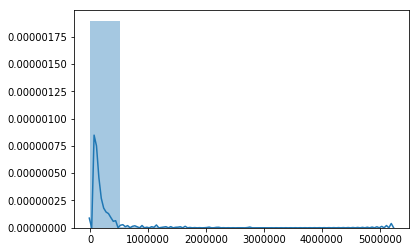

In [5]:
sns.distplot(virality, bins=10)

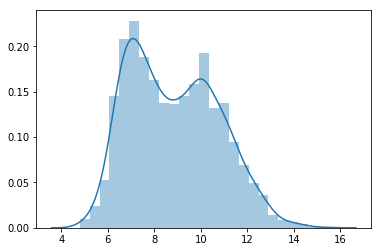

In [6]:
sns.distplot(log_vir,bins=25)

## Natural Language Processing - Word2Vec

Using NLP techniques, I represented Elon Musk's tweets using first Google's word2vec model, then a more rudimentary Bag-Of-Words model to cluster and start topic modeling. The following cells show an ineffective attempt at clustering using w2v.

In [7]:
###  Exploratory Topic Modeling on Tweet Text  ###

#Representing tweets using google's word2vec
google_vec_file = '/Users/aaronfrederick/Downloads/GoogleNews-vectors-negative300.bin'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)

In [8]:

# adding/averaging the vectors taken
# i.e.
vec_list = []
for tweet in tweet_dict_list:
    if len(tweet['cleaned_text'].split()):
        vec = np.zeros(300)
        length = 0
        for word in tweet['cleaned_text'].split():
            try:
                vec += word2vec[word]
                length += 1
            except:
                pass
        vec_list.append(vec/length)

df = pd.DataFrame(vec_list)
df = df.dropna()
df

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.072454,-0.024625,0.058594,0.033186,-0.039972,-0.063343,0.032937,-0.165261,0.184792,0.081254,...,-0.112860,0.009477,-0.079207,0.053578,-0.099446,0.057684,-0.039651,0.036710,0.006803,0.000122
1,-0.004644,0.090291,0.012717,0.109823,-0.031575,-0.003866,0.068459,-0.132339,0.038651,0.027176,...,-0.088265,0.061783,-0.093239,0.024976,-0.095835,-0.000815,0.076213,0.038523,-0.008263,-0.043274
2,-0.047811,0.061171,-0.048217,-0.002238,-0.023933,-0.082445,-0.033680,-0.171441,0.059923,0.073519,...,0.002821,0.072618,-0.031616,0.112864,0.033895,-0.025770,-0.060350,0.023763,-0.072781,-0.036797
3,0.025079,0.030064,0.008903,-0.024074,-0.104015,-0.039137,0.030489,-0.080895,0.009925,0.059704,...,-0.050465,0.069150,-0.098564,0.060749,-0.049210,-0.023532,-0.031057,-0.029390,-0.009035,-0.015418
4,-0.044421,0.126660,-0.027881,0.016016,-0.105750,-0.167725,0.120245,-0.225195,0.040039,0.010547,...,-0.014233,0.107117,-0.057568,0.083105,0.049194,-0.104397,-0.066772,0.058252,0.019434,-0.052588
5,0.093335,0.107898,-0.036650,0.040613,-0.033081,-0.086823,0.036096,-0.052032,0.077673,0.088293,...,-0.039439,0.048383,-0.091992,-0.031907,0.092249,-0.057007,0.041372,0.021423,-0.007858,-0.011182
6,-0.190674,-0.017578,0.067301,0.003581,-0.201843,0.122884,0.065063,-0.144084,0.236410,0.096110,...,-0.025981,-0.017537,0.081136,0.058594,0.090257,-0.002604,0.064860,-0.139038,0.032064,0.014587
7,0.026018,-0.002610,0.092733,0.037543,0.100850,-0.012441,-0.112223,-0.214627,0.056207,0.117246,...,-0.080458,0.000034,-0.078336,0.202284,-0.021745,-0.085870,-0.159437,-0.074283,0.021240,0.096456
8,0.088538,0.023660,-0.009979,0.086138,-0.077083,-0.031869,-0.039967,-0.114062,0.125876,0.041338,...,0.078126,0.121423,-0.052805,-0.021415,-0.038961,-0.078945,0.016464,-0.079453,-0.023525,-0.032253
9,0.097656,-0.035645,0.091797,0.151367,-0.199219,0.033447,0.199219,-0.061279,-0.013733,-0.020264,...,-0.173828,0.047119,-0.058105,0.070801,-0.092773,0.236328,0.063477,-0.193359,-0.117676,0.050781


In [9]:
scores = []
for min_samples in tqdm(range(10,200,10)):
    for eps in np.logspace(-2,1,num=20):
        cluster = DBSCAN(eps = eps, min_samples = min_samples, n_jobs=-1, metric='cosine')
        try:
            scores.append((min_samples,eps,silhouette_score(df,cluster.fit_predict(df), metric = 'cosine')))
        except:
            pass       

100%|██████████| 19/19 [05:49<00:00, 17.41s/it]


In [10]:
print(scores[:5])

[(10, 0.01, 0.06158554189177352), (10, 0.01438449888287663, 0.06158554189177352), (10, 0.0206913808111479, 0.06158554189177352), (10, 0.029763514416313176, 0.06158554189177352), (10, 0.04281332398719394, 0.06158554189177352)]


In [11]:
sort_score = sorted(scores, key=lambda tup:tup[2])
print(sort_score[0])
print(sort_score[len(sort_score)-1])

(50, 0.18329807108324356, -0.18169361671202644)
(160, 0.5455594781168517, 0.274193393588466)


In [12]:
cluster_model = DBSCAN(eps = 0.47148663634573945, min_samples = 40, n_jobs=-1, metric='cosine')
print(silhouette_score(df,cluster_model.fit_predict(df), metric='cosine'))

0.2456231785614396


In [13]:
pickle.dump(cluster_model, open('elon_dbscan.pkl', 'wb'))

In [14]:
groups = cluster_model.fit_predict(df)

In [15]:
# count = 0
# for tweet in tweet_dict_list:
#     try:
#         if tweet['cluster'] != 0:
#             count += 1
#             print(tweet['full_text'], tweet['cluster'])
#     except:
#         pass
# print(count)

## Natural Language Processing - Bag-of-Words

Using a bag-of-words model, I am able to find topics in the tweets that border on coherency.  These topics will be included in the tweets as an additional 5 features to be modeled.

In [16]:
#Representing with BOW model
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")
corpus = [tweet['cleaned_text'] for tweet in tweet_dict_list]
count_vectorizer.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [17]:
counts = count_vectorizer.transform(corpus).transpose()
counts.shape

(23987, 3199)

In [18]:
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [19]:
#lda = models.LdaModel(corpus=corpus, num_topics=7, minimum_probability=0.04, id2word=id2word, passes=10)
#lda.print_topics()

In [20]:
lda2 = models.LdaModel(corpus=corpus, num_topics=5, minimum_probability=0.01, id2word=id2word, passes=10)
lda2.print_topics()

[(0,
  '0.004*"amp" + 0.004*"just" + 0.003*"coming" + 0.003*"soon" + 0.003*"like" + 0.003*"car" + 0.003*"coming soon" + 0.002*"rocket" + 0.002*"model" + 0.002*"stage"'),
 (1,
  '0.012*"amp" + 0.004*"tesla" + 0.003*"like" + 0.003*"boring" + 0.003*"model" + 0.003*"car" + 0.002*"don" + 0.002*"company" + 0.002*"exactly" + 0.002*"make"'),
 (2,
  '0.008*"tesla" + 0.007*"yes" + 0.005*"amp" + 0.003*"yeah" + 0.003*"just" + 0.003*"sure" + 0.002*"good" + 0.002*"spacex" + 0.002*"hat" + 0.002*"right"'),
 (3,
  '0.006*"amp" + 0.005*"tesla" + 0.003*"people" + 0.003*"just" + 0.002*"car" + 0.002*"work" + 0.002*"like" + 0.002*"lot" + 0.002*"cars" + 0.001*"model"'),
 (4,
  '0.007*"model" + 0.006*"amp" + 0.006*"tesla" + 0.005*"falcon" + 0.005*"launch" + 0.003*"good" + 0.003*"just" + 0.003*"heavy" + 0.002*"falcon heavy" + 0.002*"time"')]

In [21]:
topic_spread = list(lda2.get_document_topics(corpus))

container = []
for doc in topic_spread:
    tspread = []
    for i in range(5):
        try:
            tspread.append(doc[i][1])
        except:
            tspread.append(0)
    container.append(tspread)

In [22]:
pd.DataFrame(container)

,0,1,2,3,4
0,0.011612,0.011313,0.011271,0.954650,0.011153
1,0.010065,0.010102,0.010062,0.959594,0.010177
2,0.010419,0.958670,0.010412,0.010093,0.010405
3,0.979764,0.000000,0.000000,0.000000,0.000000
4,0.025652,0.025186,0.025761,0.898052,0.025349
5,0.968424,0.000000,0.000000,0.000000,0.000000
6,0.100010,0.100011,0.599958,0.100011,0.100010
7,0.963558,0.000000,0.000000,0.000000,0.000000
8,0.968786,0.000000,0.000000,0.000000,0.000000
9,0.200000,0.200000,0.200000,0.200000,0.200000


In [23]:
for index, tweet in enumerate(tweet_dict_list):
    for i in range(5):
        tweet[f'topics{i}'] = container[index][i]

In [24]:
tweet_dict_list[0]

{'_id': ObjectId('5be4e57bcff0e50531552751'),
 'created_at': datetime.datetime(2018, 11, 8, 14, 23, 18),
 'favorite_count': 0,
 'retweet_count': 1000,
 'full_text': 'RT @InsideEVs: Holy cow! The @Tesla #Model3 currently represents almost 36% of the total U.S. plug-in electric car market and together with…',
 'screen_name': 'elonmusk',
 'virality': 10000,
 'cleaned_text': 'holy cow! the #model3 currently represents almost 36% the total u.s. plug-in electric car market and together with…',
 'log_vir': 9.210340371976184,
 'topics0': 0.011612421,
 'topics1': 0.011313328,
 'topics2': 0.011271361,
 'topics3': 0.9546502,
 'topics4': 0.011152626}

## Visualizing Tesla Stock Prices

Using a csv sourced from http://markets.financialcontent.com/stocks/quote/historical?Symbol=NQ%3ATSLA, I will visualize the recent history of Tesla's stock prices to see if there is a correlation between Elon Musk's tweets and the perceived value of his company's stock.

In [25]:
stock1 = pd.read_csv('historical.csv')
stock2 = pd.read_csv('historical2.csv')
stock_df = stock1.append(stock2)

stock_df

,Symbol,Date,Open,High,Low,Close,Volume,Change,% Change
0,TSLA,11/12/18,348.37,349.78,330.34,331.28,6924466,-19.23,-5.49%
1,TSLA,11/09/18,349.00,354.00,345.23,350.51,5098800,-0.89,-0.25%
2,TSLA,11/08/18,348.50,357.58,348.44,351.40,7082839,3.24,0.93%
3,TSLA,11/07/18,343.34,351.18,340.80,348.16,7370512,7.10,2.08%
4,TSLA,11/06/18,339.07,348.80,336.09,341.06,6755273,-0.34,-0.10%
5,TSLA,11/05/18,340.50,343.95,330.14,341.40,7826329,-5.01,-1.45%
6,TSLA,11/02/18,343.74,349.20,340.91,346.41,7807900,2.13,0.62%
7,TSLA,11/01/18,338.26,347.84,334.73,344.28,7995314,6.96,2.06%
8,TSLA,10/31/18,332.54,342.00,329.10,337.32,7621452,7.42,2.25%
9,TSLA,10/30/18,328.39,337.90,322.26,329.90,9123093,-4.95,-1.48%


In [30]:
trim_df = stock_df[['Date', 'Open']]
trim_df['pure_date'] = trim_df.Date
#trim_df

In [31]:
change = []
for item in stock_df.Change:
    if item > 0:
        change.append(1)
    else:
        change.append(-1)
trim_df['Change'] = change
trim_df

,Date,Open,pure_date,Change
0,11/12/18,348.37,11/12/18,-1
1,11/09/18,349.00,11/09/18,-1
2,11/08/18,348.50,11/08/18,1
3,11/07/18,343.34,11/07/18,1
4,11/06/18,339.07,11/06/18,-1
5,11/05/18,340.50,11/05/18,-1
6,11/02/18,343.74,11/02/18,1
7,11/01/18,338.26,11/01/18,1
8,10/31/18,332.54,10/31/18,1
9,10/30/18,328.39,10/30/18,-1


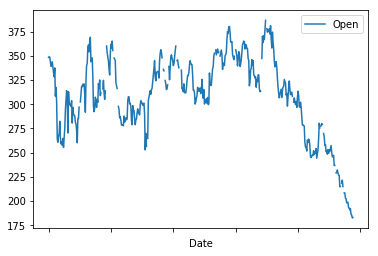

In [32]:
stock_df.plot('Date','Open')

In [33]:
trim_df = trim_df.sort_values(by = 'pure_date')

In [34]:
dates=[]
for i in range(25,275,50):
    date = trim_df.values[i][0]
    dates.append(date)
dates.reverse()
dates

['06/14/17', '05/09/17', '04/03/18', '02/27/17', '01/20/17']

In [35]:
dates = ['12/20/16', '04/20/17', '08/20/17',
         '12/20/17', '04/20/18', '08/20/18']

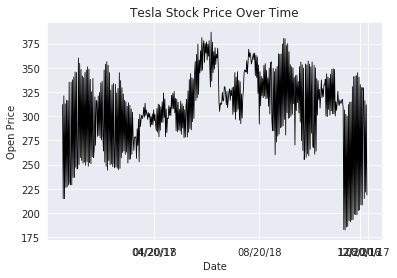

In [36]:
sns.set_style('darkgrid')
ax = sns.lineplot(x=trim_df.pure_date,y=trim_df.Open, linewidth=0.8,color='black')
ax.set(title='Tesla Stock Price Over Time',
       xlabel='Date',
       xticks=dates,
      ylabel='Open Price')
plt.show()

In [37]:
sentences = []
for tweet in tweet_dict_list:
    sentences.append(tweet['cleaned_text'])

In [38]:
analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print(sentence)
    print(vs)
    print()

holy cow! the #model3 currently represents almost 36% the total u.s. plug-in electric car market and together with…
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

would like thank robyn for joining the team. great respect. very much look forward working together.
{'neg': 0.0, 'neu': 0.496, 'pos': 0.504, 'compound': 0.9042}

no, we’re building bfr dev ship supersonic through landing tests boca chica, texas
{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'compound': -0.296}

won’t land propulsively for those reasons. ultra light heat shield &amp; high mach control surfaces are what can’t test well without orbital entry. think have handle propulsive landings.
{'neg': 0.0, 'neu': 0.928, 'pos': 0.072, 'compound': 0.2732}

aiming for orbital flight june
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

mod spacex tech tree build: falcon second stage will upgraded like mini-bfr ship
{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'compound': 0.3612}

but comments are
{'neg': 0.0, 'neu': 1.0, '


will transport your car all the way into your garage
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

thoughtful feedback
{'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.3818}

due large increase vehicle delivery volume north america, tesla customers may experience longer response times. resolving this our top priority.
{'neg': 0.0, 'neu': 0.717, 'pos': 0.283, 'compound': 0.6908}

apologies, working this exact issue right now
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

#neverforget there 9/11 tribute mars. the hardware with the flag spirit made aluminum recovere…
{'neg': 0.0, 'neu': 0.884, 'pos': 0.116, 'compound': 0.1779}

looks sus when paint cars red
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

best show the multiverse!
{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.6696}

no, service will stock all colors
{'neg': 0.306, 'neu': 0.694, 'pos': 0.0, 'compound': -0.296}

love that red. tried every possible way make red look without floating special

{'neg': 0.167, 'neu': 0.733, 'pos': 0.1, 'compound': -0.2514}

think the person who attacked twitter will survive somehow
{'neg': 0.273, 'neu': 0.727, 'pos': 0.0, 'compound': -0.4588}

thanks for correcting me. meant say over half million people.
{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'compound': 0.4404}

elon musk shanghai signs prelim agreement for tesla factory china with 500k vehicle capacity
{'neg': 0.0, 'neu': 0.802, 'pos': 0.198, 'compound': 0.4939}

please lmk contamination levels any kind when you test the water
{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'compound': 0.6908}

please lmk results your water tests
{'neg': 0.0, 'neu': 0.685, 'pos': 0.315, 'compound': 0.3182}

when you’re there next week, are you planning test water sources for lead?
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

should very soon. we’ve already made around 100 model performance cars for test drives stores.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

exactly
{'neg': 0.0, 'neu': 1.0

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

tesla semi truck mad max mode
{'neg': 0.39, 'neu': 0.61, 'pos': 0.0, 'compound': -0.4939}

almost forgot sinclair spectrum &amp; spectravideo before pc. sinclair had amazing games, especially elite.
{'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'compound': 0.5859}

vic -&gt; ibm
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

road, hawthorne
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

.sus
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

420 haha
{'neg': 0.0, 'neu': 0.25, 'pos': 0.75, 'compound': 0.4588}

had way with words
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

was dying use the word sus
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

working the factory
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

expanding the tour soon. many cool things see. tesla car factory has 3rd largest footprint any building earth. maybe 1st you inc

actually, hyperloop draws near vacuum tube &amp; each pod powered electric motors. opposite pneumatically powered.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

tesla model owner says vehicle ‘performed miraculously’ high-speed rear-end crash, all occupants are safe
{'neg': 0.153, 'neu': 0.682, 'pos': 0.165, 'compound': 0.0516}

would love india. some challenging government regulations, unfortunately. deepak ahuja, our cfo, from india. tesla will there soon believes should.
{'neg': 0.095, 'neu': 0.675, 'pos': 0.23, 'compound': 0.5267}

good progress. really proud this design &amp; spacex propulsion team. this engine something special.
{'neg': 0.0, 'neu': 0.459, 'pos': 0.541, 'compound': 0.8955}

peace
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.5423}

love the space cowboy esthetic
{'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.6369}


{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

risk stating the extremely obvious, against threats violence &amp; abusiv

taunts with his speed
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

just ordinary snail
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

his name gary &amp; he’s snail
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

skip forward see the most boring presentation ever
{'neg': 0.27, 'neu': 0.73, 'pos': 0.0, 'compound': -0.3804}

excited for partnership with metro
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.34}

lol
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4215}

listening realiti
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

yeah, there are thousands supercharger locations going through permitting/construction, including that area. will publish updated map the next few days.
{'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'compound': 0.296}

yes
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4019}

will presenting &amp; taking questions about the boring company plans for los angeles 7p

not enough ignition fluid light the outer two engines after several three engine relights. fix pretty obvious.
{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'compound': 0.4939}

east, support high flight rates for and dual ocean landings for side boosters
{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'compound': 0.4019}


{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

shortfall gravitas
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

third under construction
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

under consideration. we’ve already stretched the upper stage once. easiest part the rocket change. fairing flying soon, also has slightly larger diameter. could make fairing much longer need &amp; will bfr takes longer than expected.
{'neg': 0.0, 'neu': 0.924, 'pos': 0.076, 'compound': 0.4215}

side boosters landing droneships &amp; center expended only ~10% performance penalty fully expended. cost only slightly higher than expended f9, around $95m.
{'neg': 0.125, 'neu': 0

{'neg': 0.065, 'neu': 0.935, 'pos': 0.0, 'compound': -0.0667}

what does look like?
{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'compound': 0.3612}

racing video part
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

model races gasoline sports car while towing sports car
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

electric pods for sure. rails maybe, maybe not.
{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'compound': 0.3182}

loop like hyperloop, but without drawing vacuum inside the tube. don’t need get rid air friction for short routes.
{'neg': 0.0, 'neu': 0.911, 'pos': 0.089, 'compound': 0.1901}

kinda
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

the boring company will compete fund, build &amp; operate high-speed loop connecting chicago o’hare airport downtown
{'neg': 0.133, 'neu': 0.867, 'pos': 0.0, 'compound': -0.3182}

why there flat mars society!?
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

i’ve said before, definitely martian
{'neg': 0.0, 'neu': 

$us price $aud plus import duties and sales tax
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

can't have too many direct shareholders we're required become public co. will check possible through feeder fund though.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

often comes surprise when people learn that 80% time engineering/design and just 20% other stuff
{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.2732}

diameter vehicle fits our existing factories ...
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

yes, postponed publishing order present the updated interplanetary rocket &amp; spaceship design adelaide. will the final day.
{'neg': 0.092, 'neu': 0.769, 'pos': 0.138, 'compound': 0.2263}

discussing physics tunnels with mayor vargas (who has physics background). hawthorne support for the boring company much appreciated.
{'neg': 0.099, 'neu': 0.644, 'pos': 0.258, 'compound': 0.5719}

spacex skipping red dragon for “vastly bigger ships” mars
{'neg': 0.0, 

yes
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4019}

tap cancel the screen
{'neg': 0.4, 'neu': 0.6, 'pos': 0.0, 'compound': -0.25}

just tap the voice button the steering wheel and say "play monty python" "navigate home" anything. voice commands work pretty well.
{'neg': 0.0, 'neu': 0.7, 'pos': 0.3, 'compound': 0.7717}

just depends whether you like sedan suv. sedan goes faster, suv has more room.
{'neg': 0.0, 'neu': 0.839, 'pos': 0.161, 'compound': 0.3612}

yeah, coming back
{'neg': 0.0, 'neu': 0.476, 'pos': 0.524, 'compound': 0.296}

coming soon!
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

partly
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

possibly favorite skit
{'neg': 0.0, 'neu': 0.4, 'pos': 0.6, 'compound': 0.4588}

might work canada too
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

mean also
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

not yet
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

yeah
{'neg': 0.0, 'neu': 0.0, 'po

In [39]:
for tweet in tweet_dict_list:
    vs = analyzer.polarity_scores(tweet['cleaned_text'])
    tweet['sentiment'] = vs['compound']
    tweet['sent_viral'] = tweet['sentiment']*tweet['virality']


In [40]:
tweet_dict_list[0]

{'_id': ObjectId('5be4e57bcff0e50531552751'),
 'created_at': datetime.datetime(2018, 11, 8, 14, 23, 18),
 'favorite_count': 0,
 'retweet_count': 1000,
 'full_text': 'RT @InsideEVs: Holy cow! The @Tesla #Model3 currently represents almost 36% of the total U.S. plug-in electric car market and together with…',
 'screen_name': 'elonmusk',
 'virality': 10000,
 'cleaned_text': 'holy cow! the #model3 currently represents almost 36% the total u.s. plug-in electric car market and together with…',
 'log_vir': 9.210340371976184,
 'topics0': 0.011612421,
 'topics1': 0.011313328,
 'topics2': 0.011271361,
 'topics3': 0.9546502,
 'topics4': 0.011152626,
 'sentiment': 0.0,
 'sent_viral': 0.0}

In [41]:
tweet_values = ['created_at','favorite_count','retweet_count',
                'virality','sentiment','sent_viral', 'log_vir',
               'topics0','topics1','topics2','topics3','topics4']

clean_dict_list = []
for tweet in tweet_dict_list:
    vals_for_df = {}
    for key in tweet_values:
        vals_for_df[key] = tweet[key]
    clean_dict_list.append(vals_for_df)

clean_dict_list[1]

{'created_at': datetime.datetime(2018, 11, 8, 8, 40, 37),
 'favorite_count': 17656,
 'retweet_count': 577,
 'virality': 23426,
 'sentiment': 0.9042,
 'sent_viral': 21181.7892,
 'log_vir': 10.06160179562982,
 'topics0': 0.010064755,
 'topics1': 0.010102206,
 'topics2': 0.010062323,
 'topics3': 0.95959395,
 'topics4': 0.0101767145}

In [42]:
tweet_df = pd.DataFrame(clean_dict_list)

In [43]:
import datetime

In [44]:
###  Changing the date of the tweet to be a day later to merge onto the stock dataframe  ###
    ###  This is so we can analyze the stock price the day after the tweet was sent  ###

pure_date = []           
for item in tweet_df.created_at:
    try:
        pure_date.append(datetime.date(year=item.year, month=item.month, day=item.day+1))
    except:
        pure_date.append(datetime.date(year=item.year, month=item.month+1, day=1))
pure_date

[datetime.date(2018, 11, 9),
 datetime.date(2018, 11, 9),
 datetime.date(2018, 11, 8),
 datetime.date(2018, 11, 8),
 datetime.date(2018, 11, 8),
 datetime.date(2018, 11, 8),
 datetime.date(2018, 11, 8),
 datetime.date(2018, 11, 8),
 datetime.date(2018, 11, 8),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 7),
 datetime.date(2018, 11, 6),
 datetime.date(2018, 11, 5),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date(2018, 11, 4),
 datetime.date

In [45]:
tweet_df['pure_date'] = pure_date
tweet_df

,created_at,favorite_count,log_vir,retweet_count,sent_viral,sentiment,topics0,topics1,topics2,topics3,topics4,virality,pure_date
0,2018-11-08 14:23:18,0,9.210340,1000,0.0000,0.0000,0.011612,0.011313,0.011271,0.954650,0.011153,10000,2018-11-09
1,2018-11-08 08:40:37,17656,10.061602,577,21181.7892,0.9042,0.010065,0.010102,0.010062,0.959594,0.010177,23426,2018-11-09
2,2018-11-07 21:27:00,1924,7.994295,104,-877.3440,-0.2960,0.010419,0.958670,0.010412,0.010093,0.010405,2964,2018-11-08
3,2018-11-07 20:17:44,2178,8.116118,117,914.6736,0.2732,0.979764,0.000000,0.000000,0.000000,0.000000,3348,2018-11-08
4,2018-11-07 19:32:48,3239,8.502891,169,0.0000,0.0000,0.025652,0.025186,0.025761,0.898052,0.025349,4929,2018-11-08
5,2018-11-07 19:31:07,35895,11.012628,2474,21901.3620,0.3612,0.968424,0.000000,0.000000,0.000000,0.000000,60635,2018-11-08
6,2018-11-07 16:41:23,27555,10.399555,529,0.0000,0.0000,0.100010,0.100011,0.599958,0.100011,0.100010,32845,2018-11-08
7,2018-11-07 00:44:31,973,7.434257,72,259.1983,0.1531,0.963558,0.000000,0.000000,0.000000,0.000000,1693,2018-11-08
8,2018-11-07 00:39:43,127144,12.132448,5866,-144611.2532,-0.7783,0.968786,0.000000,0.000000,0.000000,0.000000,185804,2018-11-08
9,2018-11-06 22:58:25,278276,13.199298,26171,0.0000,0.0000,0.200000,0.200000,0.200000,0.200000,0.200000,539986,2018-11-07


In [46]:
grouped = tweet_df.groupby('pure_date', as_index=False).sum()
trimdate = []
for item in trim_df.Date:
    trimdate.append(datetime.date(year = 2000+int(item[-2:]), month = int(item[:2]), day = int(item[3:5])))
trim_df['pure_date'] = trimdate
combined = trim_df.merge(grouped,on='pure_date')
combined

,Date,Open,pure_date,Change,favorite_count,log_vir,retweet_count,sent_viral,sentiment,topics0,topics1,topics2,topics3,topics4,virality
0,01/04/18,312.87,2018-01-04,-1,77925,33.687093,17513,142660.5846,1.3273,1.966625,0.020051,0.020079,0.020005,0.919841,253055
1,01/08/18,316.00,2018-01-08,1,200055,37.353653,18214,6985.1086,1.2629,0.900282,1.189471,0.621130,1.073826,0.192023,382195
2,01/09/18,335.16,2018-01-09,-1,21918,21.789502,8591,0.0000,0.0000,1.488243,0.031177,0.031227,0.031306,0.418046,107828
3,01/10/18,NaN,2018-01-10,1,9859,16.739934,261,552.0770,0.3182,0.101994,0.848505,0.845874,0.101585,0.102041,12469
4,01/16/18,337.54,2018-01-16,1,1249,23.477577,1383,10443.6904,1.3295,1.045274,0.511387,0.210161,1.004118,0.210104,15079
5,01/19/18,345.00,2018-01-19,1,1214,17.346345,2032,14231.5040,0.7184,0.061474,0.061277,0.061182,1.505068,0.310999,21534
6,01/25/18,348.27,2018-01-25,-1,87255,23.069790,19193,30035.8400,0.1280,1.937513,0.000000,0.000000,0.000000,0.000000,279185
7,01/29/18,339.85,2018-01-29,1,1011612,160.006948,200720,869738.7453,3.9237,7.374570,2.922539,0.641556,1.578559,2.417511,3018812
8,01/30/18,345.14,2018-01-30,-1,196569,73.600635,25136,250404.5101,1.5613,2.350078,0.767409,2.779161,0.657031,1.446321,447929
9,01/31/18,347.51,2018-01-31,1,19149,10.188253,744,0.0000,0.0000,0.200000,0.200000,0.200000,0.200000,0.200000,26589


In [47]:
combined.drop(['Date','Open','Change','pure_date'], axis=1).head(10)

,favorite_count,log_vir,retweet_count,sent_viral,sentiment,topics0,topics1,topics2,topics3,topics4,virality
0,77925,33.687093,17513,142660.5846,1.3273,1.966625,0.020051,0.020079,0.020005,0.919841,253055
1,200055,37.353653,18214,6985.1086,1.2629,0.900282,1.189471,0.621130,1.073826,0.192023,382195
2,21918,21.789502,8591,0.0000,0.0000,1.488243,0.031177,0.031227,0.031306,0.418046,107828
3,9859,16.739934,261,552.0770,0.3182,0.101994,0.848505,0.845874,0.101585,0.102041,12469
4,1249,23.477577,1383,10443.6904,1.3295,1.045274,0.511387,0.210161,1.004118,0.210104,15079
5,1214,17.346345,2032,14231.5040,0.7184,0.061474,0.061277,0.061182,1.505068,0.310999,21534
6,87255,23.069790,19193,30035.8400,0.1280,1.937513,0.000000,0.000000,0.000000,0.000000,279185
7,1011612,160.006948,200720,869738.7453,3.9237,7.374570,2.922539,0.641556,1.578559,2.417511,3018812
8,196569,73.600635,25136,250404.5101,1.5613,2.350078,0.767409,2.779161,0.657031,1.446321,447929
9,19149,10.188253,744,0.0000,0.0000,0.200000,0.200000,0.200000,0.200000,0.200000,26589


## Modeling

Taking the dataframe constructed above, I will train a number of classifiers to see which perform best and have potential predictive power on Tesla's stock price. Models used include:

    -Logistic Regression
    -Linear SVC
    -RBF SVC
    -KNearest Neighbors
    -Decision Tree
    -Random Forest
    -Gradient Boosting
    -XGBoost

In [48]:
X = combined.drop(['Date','Open','Change','pure_date'], axis=1)
y = combined['Change']

In [49]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3, shuffle=False)

In [50]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
###  GridSearch Cross-Validation  ###

models1 = [LogisticRegression(),
          svm.LinearSVC(),
          svm.SVC(kernel = 'rbf')]
grid = {'C':np.logspace(-3,2,10)}
for model in models1:
    gscv = GridSearchCV(model,param_grid=grid,n_jobs=-1,cv=10)
    gscv.fit(X_train,y_train)
    print(gscv.best_estimator_)
    print(gscv.best_score_)
    print()
    #print(gscv)

models2 = KNeighborsClassifier()
grid={'n_neighbors' : range(2,50,1)}
gscv2 = GridSearchCV(models2,param_grid=grid,n_jobs=-1,cv=10)
gscv2.fit(X_train,y_train)
print(gscv2.best_estimator_)
print(gscv2.best_score_)
print()

models3 =[DecisionTreeClassifier(),
          RandomForestClassifier(),
          GradientBoostingClassifier()]
grid = {}
for model in models3:
    gscv3 = GridSearchCV(model,param_grid=grid,n_jobs=-1,cv=10)
    gscv3.fit(X_train,y_train)
    print(gscv3.best_estimator_)
    print(gscv3.best_score_)
    print()

LogisticRegression(C=0.1668100537200059, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
0.5470085470085471

LinearSVC(C=0.01291549665014884, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
0.5427350427350427

SVC(C=0.5994842503189409, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.5170940170940171

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=36, p=2,
           weights='uniform')
0.572649572

In [52]:
###  Train-Test Final Evaluation  ###

topscore=0
for i in np.logspace(-3,2,10):
    logreg = LogisticRegression(C=i)
    logreg.fit(X_train,y_train)
    if logreg.score(X_test,y_test)>topscore:
        topscore = logreg.score(X_test,y_test)
        top_i = i
print('LOGREG - C=', top_i)
print('Accuracy:',topscore)
print()

topscore = 0
for i in np.logspace(-3,2,10):
    lsvc = svm.LinearSVC(C=i)
    lsvc.fit(X_train,y_train)
    if lsvc.score(X_test,y_test) > topscore:
        topscore = lsvc.score(X_test,y_test)
        top_i = i
print('LSVM - C=', top_i)
print('Accuracy:',topscore)
print()

topscore=0
for i in np.logspace(-3,2,10):
    svc = svm.SVC(kernel = 'rbf', gamma = i)
    svc.fit(X_train,y_train)
    if svc.score(X_test,y_test) < topscore:
        topscore=svc.score(X_test,y_test)
        top_i = i
print('RBFSVM - gamma=', top_i)
print('Accuracy:',topscore)
print()


topscore=0
for i in range(2,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    if knn.score(X_test,y_test) > topscore:
        topscore=knn.score(X_test,y_test)
        top_i = i
print(f'KNN with {top_i} Neighbors - Accuracy:', topscore)
print()


dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
print('DT - Accuracy:', dt.score(X_test,y_test))
print()

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
print('RFC - Accuracy:', rfc.score(X_test,y_test))
print()

gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
print('GBC - Accuracy:', gbc.score(X_test,y_test))
print()

LOGREG - C= 0.001
Accuracy: 0.5742574257425742

LSVM - C= 2.1544346900318843
Accuracy: 0.5544554455445545

RBFSVM - gamma= 2.1544346900318843
Accuracy: 0

KNN with 4 Neighbors - Accuracy: 0.5742574257425742

DT - Accuracy: 0.45544554455445546

RFC - Accuracy: 0.49504950495049505

GBC - Accuracy: 0.504950495049505



In [53]:
###  Cross Validating XGBoost  ###

kf = KFold(n_splits=5, shuffle=False)
mat_list = []
for train_index, test_index in kf.split(X):
    X_train1 = X.iloc[train_index]
    y_train1 = y[train_index]
    xgb_model = xgb.XGBClassifier().fit(X_train1,y_train1)
    predictions = xgb_model.predict(X.iloc[test_index])
    actuals = y[test_index]
    mat_list.append(confusion_matrix(actuals, predictions))
matrix = mat_list[0]
for n_mat in range(1,5):
    for i in range(2):
        for j in range(2):
            matrix[i][j] += mat_list[n_mat][i][j]
true = matrix[0][0] + matrix[1][1]
false = matrix[1][0] + matrix[0][1]
print('XGBoost Accuracy in cross validation: ', true/(true+false))

XGBoost Accuracy in cross validation:  0.4835820895522388


In [54]:
###  Train-Test Evaluating XGBoost  ###

xgb_model = xgb.XGBClassifier().fit(X_train,y_train)
predictions = xgb_model.predict(X_test)
actuals = y_test
print(xgb_model.score(X_test,y_test))
print(confusion_matrix(actuals, predictions))

0.46534653465346537
[[23 34]
 [20 24]]


## Hypothesis Testing

Examining results to see if there is conclusive evidence that Musk's Twitter impacts stock prices.

In [55]:
len(y[y==1])

162

In [56]:
len(y[y==-1])

173

In [57]:
from scipy.stats import binom
prob = 1 - binom.cdf(57, 100.5, 0.5)

print(str(round(prob*100, 1))+"%")

6.7%


In [58]:
335*0.6*0.3

60.3

In [59]:
335*0.3

100.5